# Quality Control

A notebook to check the decisions made by various quality control criteria

In [1]:
import os
import obspy
import rf
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


In [2]:
data_root = "rf_data"
network = "7J"
data_dir = os.path.join(data_root, f"{network}-analysis")
run = max(
    [
        os.path.join(data_dir, d)
        for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d))
    ],
    key=os.path.getmtime,
)

In [3]:
# raw waveforms
waveforms = obspy.read(os.path.join(data_dir, f"{network}_event_waveforms_*.h5"))
stations = set([w.stats.station for w in waveforms])
print(f"{len(stations)} stations with waveforms")

25 stations with waveforms


In [4]:
# initial rfs
init_rfs = rf.read_rf(os.path.join(run, f"{network}_rf.h5"))
init_rfs = init_rfs.select(channel="??R")
traces_with_nans = 0
init_rf_station_dict = defaultdict(rf.RFStream)
lens = []
for trace in init_rfs:
    init_rf_station_dict[trace.stats.station] += rf.RFStream([trace])
    lens.append(trace.data.size)
    if np.any(np.isnan(trace.data)):
        traces_with_nans += 1
print(f"{len(init_rf_station_dict)} stations with RFs")
for k, v in init_rf_station_dict.items():
    print(f"Station {k} has {len(v)} RFs")
print(f"{traces_with_nans} traces found to have NaNs")
print(f"{len(set(lens))} different trace lengths: {set(lens)}")
print(f"{sum(np.array([len(v) for v in init_rf_station_dict.values()]) < 10)} stations with fewer than 10 RFs")

25 stations with RFs
Station CP01 has 118 RFs
Station CP02 has 122 RFs
Station CP03 has 128 RFs
Station CP04 has 39 RFs
Station CP05 has 117 RFs
Station CP06 has 72 RFs
Station CP07 has 14 RFs
Station CP08 has 78 RFs
Station CP09 has 109 RFs
Station CP10 has 110 RFs
Station CP11 has 70 RFs
Station CP12 has 52 RFs
Station CP13 has 20 RFs
Station CP14 has 54 RFs
Station LP01 has 29 RFs
Station LP02 has 82 RFs
Station LP03 has 27 RFs
Station LP04 has 68 RFs
Station LP05 has 107 RFs
Station RP01 has 87 RFs
Station RP02 has 120 RFs
Station RP03 has 168 RFs
Station RP04 has 120 RFs
Station RP06 has 74 RFs
Station RP07 has 169 RFs
0 traces found to have NaNs
1 different trace lengths: {10000}
0 stations with fewer than 10 RFs


In [5]:
# after initial qc (removing traces with NaNs, unexpected length etc.)
qc_rfs = rf.read_rf(os.path.join(run, f"{network}_rf_qc.h5"))
qc_rfs = qc_rfs.select(channel="??R")
qc_rf_station_dict = defaultdict(rf.RFStream)
lens = []
for trace in qc_rfs:
    qc_rf_station_dict[trace.stats.station] += rf.RFStream([trace])
    lens.append(trace.data.size)
print(f"{len(qc_rf_station_dict)} stations with RFs")
for k, v in qc_rf_station_dict.items():
    print(f"Station {k} has {len(v)} RFs")
print(f"{len(set(lens))} different trace lengths: {set(lens)}")

25 stations with RFs
Station CP01 has 118 RFs
Station CP02 has 122 RFs
Station CP03 has 128 RFs
Station CP04 has 39 RFs
Station CP05 has 117 RFs
Station CP06 has 72 RFs
Station CP07 has 14 RFs
Station CP08 has 78 RFs
Station CP09 has 109 RFs
Station CP10 has 110 RFs
Station CP11 has 70 RFs
Station CP12 has 52 RFs
Station CP13 has 20 RFs
Station CP14 has 54 RFs
Station LP01 has 29 RFs
Station LP02 has 82 RFs
Station LP03 has 27 RFs
Station LP04 has 68 RFs
Station LP05 has 107 RFs
Station RP01 has 87 RFs
Station RP02 has 120 RFs
Station RP03 has 168 RFs
Station RP04 has 120 RFs
Station RP06 has 74 RFs
Station RP07 has 169 RFs
1 different trace lengths: {10000}


In [6]:
failed_qc = {k: v for k, v in init_rf_station_dict.items() if k not in qc_rf_station_dict.keys()}
print(failed_qc.keys())
# strangely, for run 20230317_142405, apart from AUJCS, these are all the stations in the latter half of the alphabetical list of stations... 
print(f"{len(init_rfs) - len(qc_rfs) - traces_with_nans}/{len(init_rfs)} dropped for length problems")

dict_keys([])
0/2154 dropped for length problems


In [7]:
# Only keep stations with 10 or more traces
rf_station_dict = {
    k: v for k, v in qc_rf_station_dict.items() if len(v) >= 10
}
print(f"{len(rf_station_dict)} stations with RFs")
for k, v in rf_station_dict.items():
    print(f"Station {k} has {len(v)} RFs")

25 stations with RFs
Station CP01 has 118 RFs
Station CP02 has 122 RFs
Station CP03 has 128 RFs
Station CP04 has 39 RFs
Station CP05 has 117 RFs
Station CP06 has 72 RFs
Station CP07 has 14 RFs
Station CP08 has 78 RFs
Station CP09 has 109 RFs
Station CP10 has 110 RFs
Station CP11 has 70 RFs
Station CP12 has 52 RFs
Station CP13 has 20 RFs
Station CP14 has 54 RFs
Station LP01 has 29 RFs
Station LP02 has 82 RFs
Station LP03 has 27 RFs
Station LP04 has 68 RFs
Station LP05 has 107 RFs
Station RP01 has 87 RFs
Station RP02 has 120 RFs
Station RP03 has 168 RFs
Station RP04 has 120 RFs
Station RP06 has 74 RFs
Station RP07 has 169 RFs


In [8]:
failed_qc = {k: v for k, v in qc_rf_station_dict.items() if k not in rf_station_dict.keys()}
print(failed_qc.keys())

dict_keys([])


In [9]:
def peak_delay(trace: rf.rfstream.RFTrace) -> float:
    return trace.times()[np.argmax(trace.data)] - (
        trace.stats.onset - trace.stats.starttime
    )

def quality_filter(stream: rf.RFStream) -> rf.RFStream:
    """ "
    Applies various final quality controlls to the RFs
    starttime and end time are in seconds relative to onset
    """
    rf_station_dict = defaultdict(rf.RFStream)
    for trace in stream:
        # Only keep traces where largest arrival is positive
        if trace[np.argmax(np.abs(trace.data))] < 0:
            continue
        # Only keep traces where largest arrival is within 2 seconds
        if peak_delay(trace) > 2:
            continue
        # Only keep traces with slope_ratio > 5
        if trace.stats.slope_ratio < 5:
            continue
        rf_station_dict[trace.stats.station] += rf.RFStream([trace])

    # Only keep stations with 10 or more traces
    rf_station_dict = {
        k: v.sort(["back_azimuth"]) for k, v in rf_station_dict.items() if len(v) >= 10
    }

    return sum(rf_station_dict.values(), start=rf.RFStream())

In [10]:
# Slow peak delay
slow_traces = rf.RFStream()
for tr in qc_rfs:
    if peak_delay(tr) > 2:
        slow_traces += tr

print(f"{len(slow_traces)}/{len(qc_rfs)} traces dropped for being too slow")

794/2154 traces dropped for being too slow


In [11]:
# negative ploarity peak
negative_traces = rf.RFStream()
for tr in qc_rfs:
    if tr[np.argmax(np.abs(trace.data))] < 0:
        negative_traces += tr

print(f"{len(negative_traces)}/{len(qc_rfs)} dropped for negative polarity peak")

1007/2154 dropped for negative polarity peak


In [22]:
bad_slope_ratio = rf.RFStream()
for tr in qc_rfs:
    if tr.stats.slope_ratio < 5:
        bad_slope_ratio += tr

print(f"{len(bad_slope_ratio)}/{len(qc_rfs)} dropped for low slope ratio")

1675/2154 dropped for low slope ratio


In [21]:
big_small_amps = rf.RFStream()
for tr in qc_rfs:
    if tr.stats.

2154 Trace(s) in Stream:

Prf 7J.CP01..BHR | -50.0s - 150.0s onset:2006-06-22T11:04:15.720000Z | 50.0 Hz, 10000 samples | mag:6.1 dist:70.6 baz:21.4 slow:6.08
...
(2152 other traces)
...
Prf 7J.RP07..BHR | -50.0s - 150.0s onset:2007-05-18T16:10:35.880000Z | 50.0 Hz, 9999 samples | mag:5.5 dist:65.6 baz:16.3 slow:6.45

[Use "print(Stream.__str__(extended=True))" to print all Traces]

Looking at why some traces have length 9999 or 10001 instead of 10000.

Should be due to some precision error when trimming.

RFs are trimed to -50 to 150 seconds around `onset` by default.

We resample to a sample rate of 50 Hz -> 200 seconds at 50 samples per second gives 10000 samples

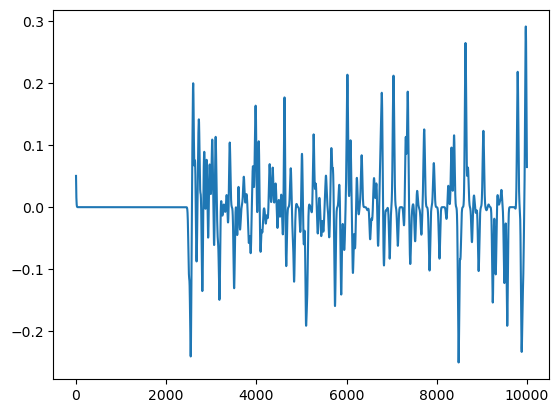

In [13]:
for _tr in init_rfs:
    if _tr.data.size == 9999:
        tr = _tr
        break
plt.plot(tr)

In [14]:
tr.stats.onset

2007-05-18T16:10:35.880000Z

In [15]:
tr._seconds2utc(-50.0, "onset"), tr._seconds2utc(150.0, "onset") # how RFStream.trim2 finds start and end times

(2007-05-18T16:09:45.880000Z, 2007-05-18T16:13:05.880000Z)

In [16]:
tr.stats.starttime == tr._seconds2utc(-50.0, "onset"), tr.stats.endtime == tr._seconds2utc(150.0, "onset")

(True, False)

In [17]:
(tr.stats.endtime - tr.stats.starttime) * tr.stats.sampling_rate + 1 # +1 to include endpoints

10000.0

In [18]:
tr.data = tr.data[:-1]

In [19]:
tr.stats

                  network: 7J
                  station: RP07
                 location: 
                  channel: BHR
                starttime: 2007-05-18T16:09:45.880000Z
                  endtime: 2007-05-18T16:13:05.840000Z
            sampling_rate: 50.0
                    delta: 0.02
                     npts: 9999
                    calib: 1.0
   _fdsnws_dataselect_url: http://auspass.edu.au/fdsnws/dataselect/1/query
                  _format: H5
                  amp_max: 0.2912064214263075
                  amp_rms: 0.059086489059630244
             arrival_time: 1969-12-31T23:59:59.000000Z
             back_azimuth: 16.292121801802406
     delta_log10_amp_20pc: 3.8817675766787603
     delta_log10_amp_80pc: 3.7178519538877577
      delta_log10_rms_amp: 2.952441731418898
delta_mean_log10_cplx_amp: 3.8009640969423906
                 distance: 65.6033006985303
                  entropy: 4.331073204892652
              event_depth: 68.2393
                 event_id: smi:ISC/

In [20]:
print(waveforms.select(station=tr.stats.station).__str__(extended=True))

732 Trace(s) in Stream:
7J.RP07..BHE | 2006-06-21T12:41:21.840000Z - 2006-06-21T12:45:01.860000Z | 50.0 Hz, 11002 samples
7J.RP07..BHN | 2006-06-21T12:41:21.840000Z - 2006-06-21T12:45:01.860000Z | 50.0 Hz, 11002 samples
7J.RP07..BHZ | 2006-06-21T12:41:21.840000Z - 2006-06-21T12:45:01.860000Z | 50.0 Hz, 11002 samples
7J.RP07..BHE | 2006-06-22T11:03:09.320000Z - 2006-06-22T11:06:49.340000Z | 50.0 Hz, 11002 samples
7J.RP07..BHN | 2006-06-22T11:03:09.320000Z - 2006-06-22T11:06:49.340000Z | 50.0 Hz, 11002 samples
7J.RP07..BHZ | 2006-06-22T11:03:09.320000Z - 2006-06-22T11:06:49.340000Z | 50.0 Hz, 11002 samples
7J.RP07..BHE | 2006-06-27T02:51:08.320000Z - 2006-06-27T02:54:48.340000Z | 50.0 Hz, 11002 samples
7J.RP07..BHN | 2006-06-27T02:51:08.320000Z - 2006-06-27T02:54:48.340000Z | 50.0 Hz, 11002 samples
7J.RP07..BHZ | 2006-06-27T02:51:08.320000Z - 2006-06-27T02:54:48.340000Z | 50.0 Hz, 11002 samples
7J.RP07..BHE | 2006-06-27T03:06:47.680000Z - 2006-06-27T03:10:27.700000Z | 50.0 Hz, 11002 samp